<a href="https://colab.research.google.com/github/microsoft/autogen/blob/main/notebook/agentchat_auto_feedback_from_code_execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto Generated Agent Chat: Task Solving with Code Generation, Execution & Debugging

AutoGen offers conversable LLM agents, which can be used to solve various tasks with human or automatic feedback, including tasks that require using tools via code.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

In this notebook, we demonstrate how to use `AssistantAgent` and `UserProxyAgent` to write code and execute the code. Here `AssistantAgent` is an LLM-based agent that can write Python code (in a Python coding block) for a user to execute for a given task. `UserProxyAgent` is an agent which serves as a proxy for the human user to execute the code written by `AssistantAgent`, or automatically execute the code. Depending on the setting of `human_input_mode` and `max_consecutive_auto_reply`, the `UserProxyAgent` either solicits feedback from the human user or returns auto-feedback based on the result of code execution (success or failure and corresponding outputs) to `AssistantAgent`. `AssistantAgent` will debug the code and suggest new code if the result contains error. The two agents keep communicating to each other until the task is done.

## Requirements

AutoGen requires `Python>=3.8`. To run this notebook example, please install:
```bash
pip install pyautogen
```

In [1]:
# %pip install pyautogen~=0.1.0

## Set your API Endpoint

The [`config_list_from_json`](https://microsoft.github.io/autogen/docs/reference/oai/openai_utils#config_list_from_json) function loads a list of configurations from an environment variable or a json file.


In [2]:
import autogen

config_list = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

It first looks for environment variable "OAI_CONFIG_LIST" which needs to be a valid json string. If that variable is not found, it then looks for a json file named "OAI_CONFIG_LIST". It filters the configs by models (you can filter by other keys as well). Only the gpt-4 models are kept in the list based on the filter condition.

The config list looks like the following:
```python
config_list = [
    {
        'model': 'gpt-4',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-4',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
    {
        'model': 'gpt-4-32k',
        'api_key': '<your Azure OpenAI API key here>',
        'api_base': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2023-06-01-preview',
    },
]
```

If you open this notebook in colab, you can upload your files by clicking the file icon on the left panel and then choose "upload file" icon.

You can set the value of config_list in other ways you prefer, e.g., loading from a YAML file.

## Example Task: Check Stock Price Change

In the example below, let's see how to use the agents in AutoGen to write a python script and execute the script. This process involves constructing a `AssistantAgent` to serve as the assistant, along with a `UserProxyAgent` that acts as a proxy for the human user. In this example demonstrated below, when constructing the `UserProxyAgent`,  we select the `human_input_mode` to "NEVER". This means that the `UserProxyAgent` will not solicit feedback from the human user. It stops replying when the limit defined by `max_consecutive_auto_reply` is reached, or when `is_termination_msg()` returns true for the received message.

In [3]:
# create an AssistantAgent named "assistant"
assistant = autogen.AssistantAgent(
    name="assistant",
    llm_config={
        "seed": 42,  # seed for caching and reproducibility
        "config_list": config_list,  # a list of OpenAI API configurations
        "temperature": 0,  # temperature for sampling
    },  # configuration for autogen's enhanced inference API which is compatible with OpenAI API
)
# create a UserProxyAgent instance named "user_proxy"
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config={
        "work_dir": "coding",
        "use_docker": False,  # set to True or image name like "python:3" to use docker
    },
)
# the assistant receives a message from the user_proxy, which contains the task description
user_proxy.initiate_chat(
    assistant,
    message="""What date is today? Compare the year-to-date gain for META and TESLA.""",
)

user_proxy (to assistant):

What date is today? Compare the year-to-date gain for META and TESLA.

--------------------------------------------------------------------------------
assistant (to user_proxy):

First, let's get the current date. We can do this using Python's built-in datetime module. 

```python
# python code
import datetime

# Get the current date
current_date = datetime.date.today()

print("Today's date is:", current_date)
```

Next, we need to get the year-to-date (YTD) gain for META (Facebook) and TESLA. We can do this by using a financial data API such as Yahoo Finance. We will need to install the yfinance package first. 

```sh
# shell script
pip install yfinance
```

After installing the yfinance package, we can use it to get the stock prices for META and TESLA. 

```python
# python code
import yfinance as yf

# Get the data for the stock Apple by specifying the stock ticker, start date, and end date
meta_data = yf.download('META','2022-01-01',str(current_date))
te

The example above involves code execution. In AutoGen, code execution is triggered automatically by the `UserProxyAgent` when it detects an executable code block in a received message and no human user input is provided. This process occurs in a designated working directory, using a Docker container by default. Unless a specific directory is specified, AutoGen defaults to the `autogen/extensions` directory. Users have the option to specify a different working directory by setting the `work_dir` argument when constructing a new instance of the `UserProxyAgent`.

The whole chat is auto-generated.

## Example Task: Plot Chart

In [4]:
# followup of the previous question
user_proxy.send(
    recipient=assistant,
    message="""Plot a chart of their stock price change YTD and save to stock_price_ytd.png.""",
)

user_proxy (to assistant):

Plot a chart of their stock price change YTD and save to stock_price_ytd.png.

--------------------------------------------------------------------------------
assistant (to user_proxy):

We can use the matplotlib library in Python to plot the stock price changes for META and TESLA. If matplotlib is not installed, you can install it using pip:

```sh
# shell script
pip install matplotlib
```

After ensuring matplotlib is installed, we can plot the stock price changes:

```python
# python code
import matplotlib.pyplot as plt

# Plot the adjusted close price of META and TESLA
meta_data['Adj Close'].plot(label='META', legend=True)
tesla_data['Adj Close'].plot(label='TESLA', legend=True, secondary_y=True)

# Title and labels
plt.title('Year-to-Date Stock Price Change for META and TESLA')
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')

# Save the figure
plt.savefig('stock_price_ytd.png')
```

This code will create a line plot of the adjusted closing pric

Let's display the generated figure.

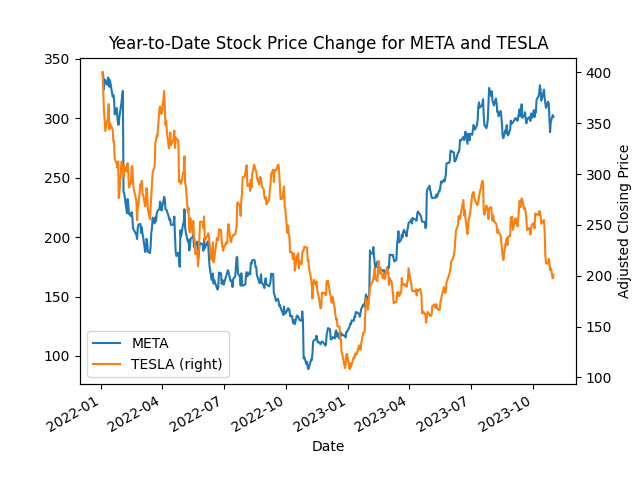

In [5]:
from IPython.display import Image

Image(filename='coding/stock_price_ytd.png')

## Use a Different Code Execution Environment

The code execution happened in a separate process, so the plot is not directly displayed in the notebook. Is it possible to change the code execution environment into IPython?

Yes! In the following we demonstrate how to extend the `UserProxyAgent` to use a different code execution environment.

In [6]:
from typing import Dict, Union
from IPython import get_ipython

class IPythonUserProxyAgent(autogen.UserProxyAgent):
    def __init__(self, name: str, **kwargs):
        super().__init__(name, **kwargs)
        self._ipython = get_ipython()

    def generate_init_message(self, *args, **kwargs) -> Union[str, Dict]:
        return super().generate_init_message(*args, **kwargs) + """
If you suggest code, the code will be executed in IPython."""

    def run_code(self, code, **kwargs):
        result = self._ipython.run_cell("%%capture --no-display cap\n" + code)
        log = self._ipython.ev("cap.stdout")
        log += self._ipython.ev("cap.stderr")
        if result.result is not None:
            log += str(result.result)
        exitcode = 0 if result.success else 1
        if result.error_before_exec is not None:
            log += f"\n{result.error_before_exec}"
            exitcode = 1
        if result.error_in_exec is not None:
            log += f"\n{result.error_in_exec}"
            exitcode = 1
        return exitcode, log, None

The implementation overrides three functions in `UserProxyAgent`:
* constructor. We get the ipython instance as the code execution environment.
* `generate_init_message`. We generate a modified initial message to send to the assistant agent, by adding the info that the execution will be performed in IPython.
* `run_code`. We execute the code with the ipython instance.

With the new `IPythonUserProxyAgent`, we are able to run the code within the current notebook environment and display the plot directly.

ipython_user_proxy (to assistant):

Plot a chart of META and TESLA stock price gain YTD
If you suggest code, the code will be executed in IPython.

--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

To plot a chart of META (Facebook) and TESLA stock price gain year-to-date (YTD), we can use the `yfinance` library in Python, which allows us to download stock data from Yahoo Finance. We will also use `matplotlib` to plot the data.

Here is the Python code to do this:

```python
# Python code
import yfinance as yf
import matplotlib.pyplot as plt

# Download historical data as dataframe
meta = yf.download('FB', start='2022-01-01')
tesla = yf.download('TSLA', start='2022-01-01')

# Calculate the YTD return
meta['YTD'] = (meta['Adj Close'] / meta['Adj Close'][0]) - 1
tesla['YTD'] = (tesla['Adj Close'] / tesla['Adj Close'][0]) - 1

# Plot the data
plt.figure(figsize=(14,7))
plt.plot(meta['YTD'], label='META')
plt.plot(tesla['YT

IndexError: index 0 is out of bounds for axis 0 with size 0


>>>>>>>> EXECUTING CODE BLOCK 1 (inferred language is python)...
ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')
/var/folders/87/bmw_pqz16xs4w5kfp6qnz71h0000gn/T/ipykernel_11409/2048845316.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meta['YTD'] = (meta['Adj Close'] / meta['Adj Close'][0]) - 1



--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

It seems like there was an issue with downloading the data for the 'FB' ticker symbol. This could be due to the recent na

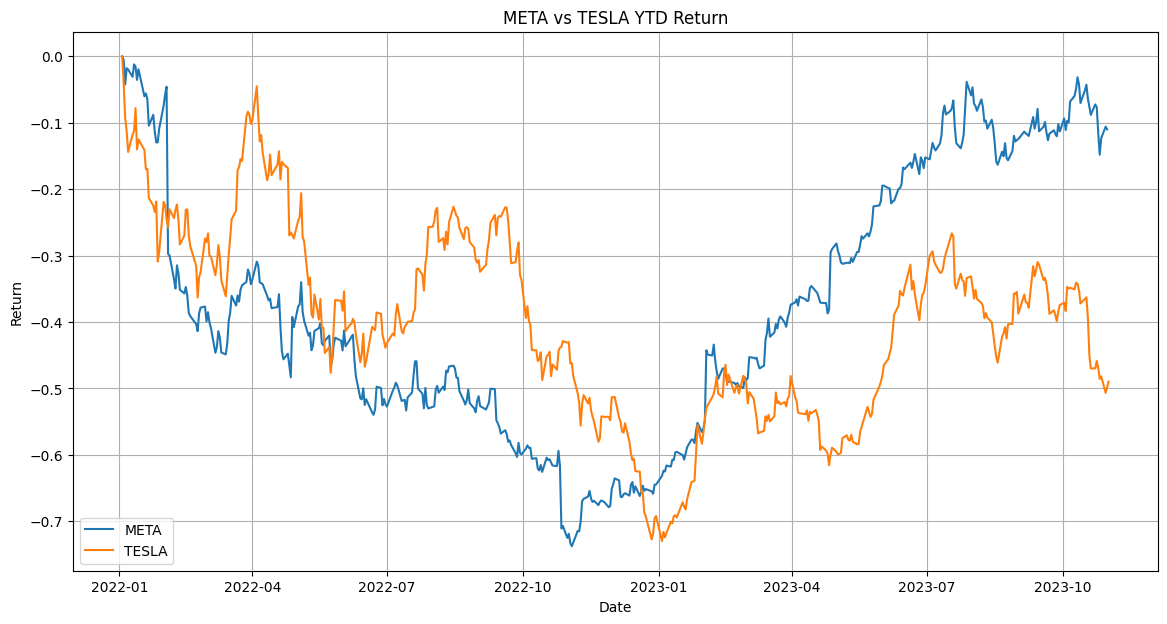

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/87/bmw_pqz16xs4w5kfp6qnz71h0000gn/T/ipykernel_11409/2590483630.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meta['YTD'] = (meta['Adj Close'] / meta['Adj Close'][0]) - 1
/var/folders/87/bmw_pqz16xs4w5kfp6qnz71h0000gn/T/ipykernel_11409/2590483630.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tesla['YTD'] = (tesla['Adj Close'] / tesla['Adj Close'][0]) - 1


-----------------

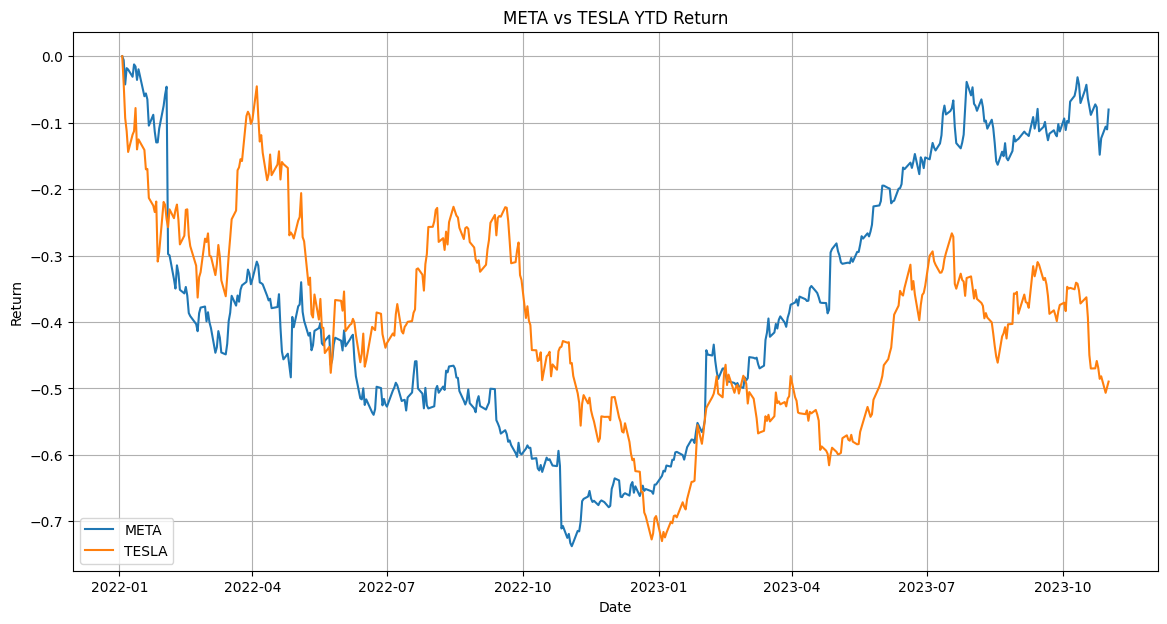

ipython_user_proxy (to assistant):

exitcode: 0 (execution succeeded)
Code output: 
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


--------------------------------------------------------------------------------
assistant (to ipython_user_proxy):

Great! The code executed successfully. The output should be a plot showing the year-to-date (YTD) return for both META and TESLA. The x-axis represents the date, and the y-axis represents the return. The blue line represents META, and the orange line represents TESLA. You can compare the performance of both stocks over the year by looking at this plot.

If you have any other tasks or need further assistance, feel free to ask.

TERMINATE

--------------------------------------------------------------------------------


In [7]:
ipy_user = IPythonUserProxyAgent(
    "ipython_user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE") or x.get("content", "").rstrip().endswith('"TERMINATE".'),
)
# the assistant receives a message from the user, which contains the task description
ipy_user.initiate_chat(
    assistant,
    message="""Plot a chart of META and TESLA stock price gain YTD""",
)